# 10. Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get you familiar with working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

Welcome to Milestone Project 3, BitPredict 💰📈!

> 🔑 Note: ⚠️ This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

## What is a time series problem?

Time series problems deal with data over time.

Such as the number of staff members in a company over 10 years, sales of computers for the past 5 years, and electricity usage for the past 50 years.

The timeline can be short (seconds/minutes) or long (years/decades). The problems you might investigate can usually be broken down into two categories.

![image0](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-example-time-series-problems.png)

|Problem Type|Examples|Output|
|--|--|--|
|**Classification**|Anomaly detection, time series identification<br>(where did this time series come from?)|Discrete (a label)|
|**Forecasting**|Predicting stock market prices,<br>forecasting future demand for a product,<br>and stocking inventory requirements|Continuous (a number)|

In both cases above, a supervised learning approach is often used. Meaning, you'd have some example data and a label associated with that data.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

Can you guess what kind of problem BitPredict 💰📈 is?

## What we're going to cover

Are you ready?

We've got a lot to go through.

- Get time series data (the historical price of Bitcoin)
    - Load in time series data using pandas/Python's CSV module
- Format data for a time series problem
    - Creating training and test sets (the wrong way)
    - Creating training and test sets (the right way)
    - Visualizing time series data
    - Turning time series data into a supervised learning problem (windowing)
    - Preparing univariate and multivariate (more than one variable) data
- Evaluating a time series forecasting model
- Setting up a series of deep learning modeling experiments
    - Dense (fully connected) networks
    - Sequence models (LSTM and 1D CNN)
    - Ensembling (combining multiple models)
    - Multivariate models
    - Replicating the N-BEATS algorithm using TensorFlow layer subclassing
- Creating a modeling checkpoint to save the best-performing model during training
- Making predictions (forecasts) with a time series model
- Creating prediction intervals for time series model forecasts
- Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
- Demonstrating why forecasting in an open system is BS (the turkey problem)

## Check for GPU

For our deep learning models to run as fast as possible, we'll need access to a GPU.

In Google Colab, you can set this up by going to Runtime -> Change runtime type -> Hardware accelerator -> GPU.

After selecting GPU, you may have to restart the runtime.

In [1]:
# Check for GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get data

To build a time series forecasting model, the first thing we're going to need is data.

And since we're trying to predict the price of Bitcoin, we'll need Bitcoin data.

Specifically, we're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

Why these dates?

Because 01 October 2013 is when our data source ([Coindesk](https://www.coindesk.com/price/bitcoin)) started recording the price of Bitcoin and 18 May 2021 is when this notebook was created.

If you're going through this notebook at a later date, you'll be able to use what you learn to predict later dates of Bitcoin, you'll just have to adjust the data source.

> 📖 Resource: To get the Bitcoin historical data, I went to the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), clicked on "all" and then clicked on "Export data" and selected "CSV".

You can find the data we're going to use on [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).

In [2]:
# Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-01-08 12:17:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2024-01-08 12:17:22 (6.58 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas

Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in **CSV (comma separated values)** format (a very common data format for time series), we'll use the pandas [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name our of the date column ("Date").

In [3]:
# Import with pandas
import pandas as pd

# Parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas that column 1 is a datetime)

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


Looking good! Let's get some more info.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


Because we told pandas to parse the date column and set it as the index, it's not in the list of columns.

You can also see there aren't many samples.

In [5]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there are only 2787 total samples.

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

For example, collecting one sample at different time frames results in:

|1 sample per timeframe|Number of samples per year|
|--|--|
|Second|	31,536,000|
|Hour|	8,760|
|Day|	365|
|Week|	52|
|Month|	12|

> 🔑 Note: The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually measured in several samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand being higher in Summer months for air conditioning than in Winter months). For more on different time series patterns, see [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html).

![image1](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-types-of-time-series-patterns.png)
*Examples of different kinds of patterns you'll see in time series data. Notice the bottom right time series (Google stock price changes) has little to no patterns, making it difficult to predict. See [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html) for full graphic.*

Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't mean we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [6]:
# Only want the closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Much better!

But that's only five days' worth of Bitcoin prices, let's plot everything we've got.

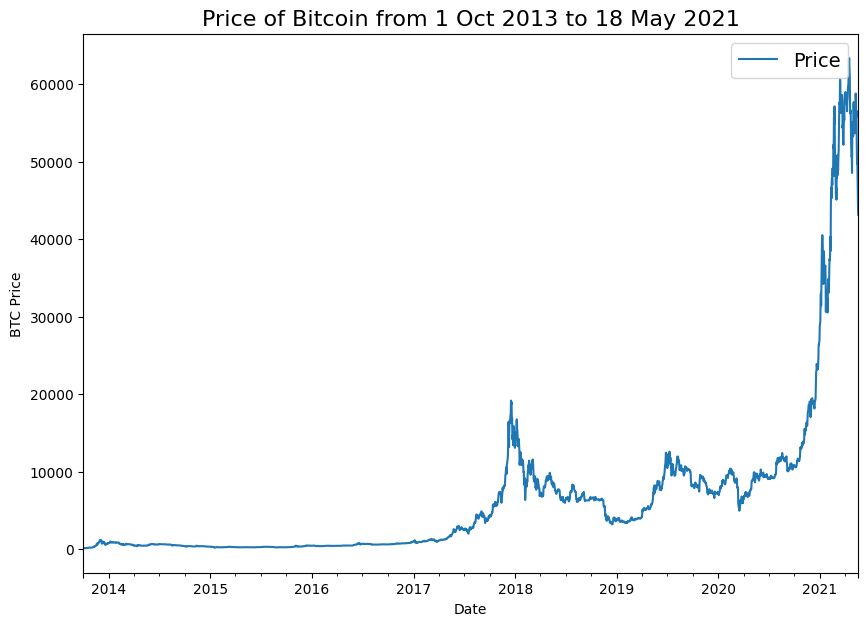

In [7]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

Woah looks like it would've been a good idea to buy Bitcoin back in 2014.

### Importing time series data with Python's CSV module

If your time series data comes in CSV form you don't necessarily have to use pandas.

You can use Python's [in-built `csv` module](https://docs.python.org/3/library/csv.html). And if you're working with dates, you might also want to use Python's [`datetime`](https://docs.python.org/3/library/datetime.html).

Let's see how we can replicate the plot we created before except this time using Python's `csv` and `datetime` modules.

> 📖 Resource: For a great guide on using Python's `csv` module, check out [Real Python's tutorial on Reading and Writing CSV files in Python](https://realpython.com/python-csv/).

In [8]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")   # read in the target CSV
    next(csv_reader)                            # skip first line (this gets rid of the column titles)

    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))    # get the dates as dates (not strings), strptime = string parse time
        btc_price.append(float(line[2]))                            # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Beautiful! Now, let's see how things look.

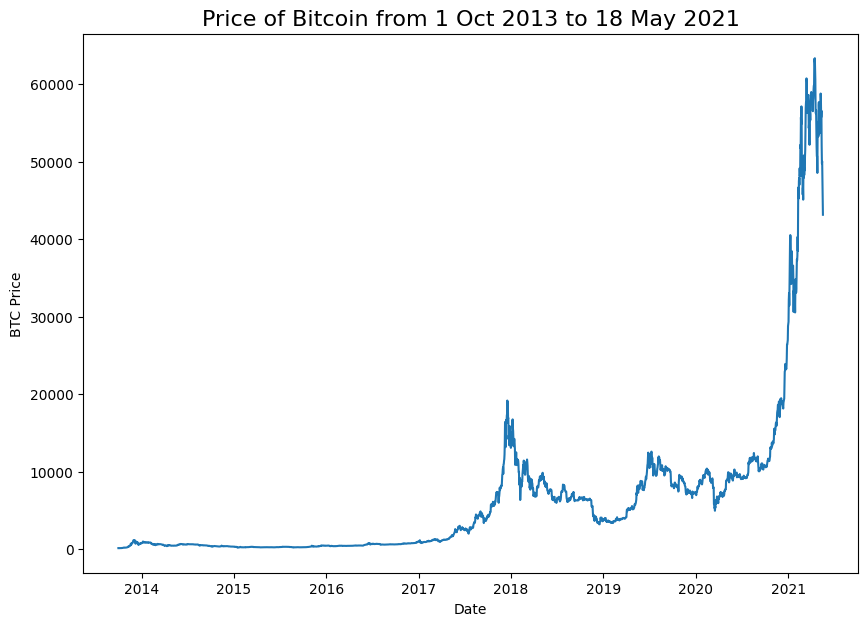

In [9]:
# Plot from CSV
import numpy as np

plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

Ho ho! Would you look at that? Just like the pandas plot. And because we formatted the `timesteps` to be `datetime` objects, `matplotlib` displays a fantastic-looking date axis.

## Format Data Part 1: Creating train and test sets for time series data

Alrighty. What's next?

If you guessed preparing our data for a model, you'd be right.

What's the most important first step for preparing any machine learning dataset?

Scaling?

No...

Removing outliers?

No...

How about creating train and test splits?

Yes!

Usually, you could create a train and test split using a function like Scikit-Learn's outstanding [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) but as we'll see in a moment, this doesn't cut it for time series data.

But before we do create splits, it's worth talking about what *kind* of data we have.

In time series problems, you'll either have **univariate** or **multivariate** data.

Can you guess what our data is?

- **Univariate** time series data deals with *one* variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
- **Multivariate** time series data deals with *more than one* variable, for example, predicting electricity demand using the day of the week, time of year, and number of houses in a region.

![image2](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-univariate-and-multivariate-time-series-data.png)
*Example of univariate and multivariate time series data. Univariate involves using the target to predict the target. Multivariate involves using the target as well as another time series to predict the target.*

### Create train & test sets for time series (the wrong way)

Okay, we've figured out we're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables).

How about we first see the *wrong* way for splitting time series data?

Let's turn our DataFrame index and column into NumPy arrays.

In [10]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

Now we'll use the ever-find faithful `train_test_split` from Scikit-Learn to create our train and test sets.

In [11]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

Looks like the splits worked well, but let's not trust numbers on a page, let's visualize, visualize, visualize!

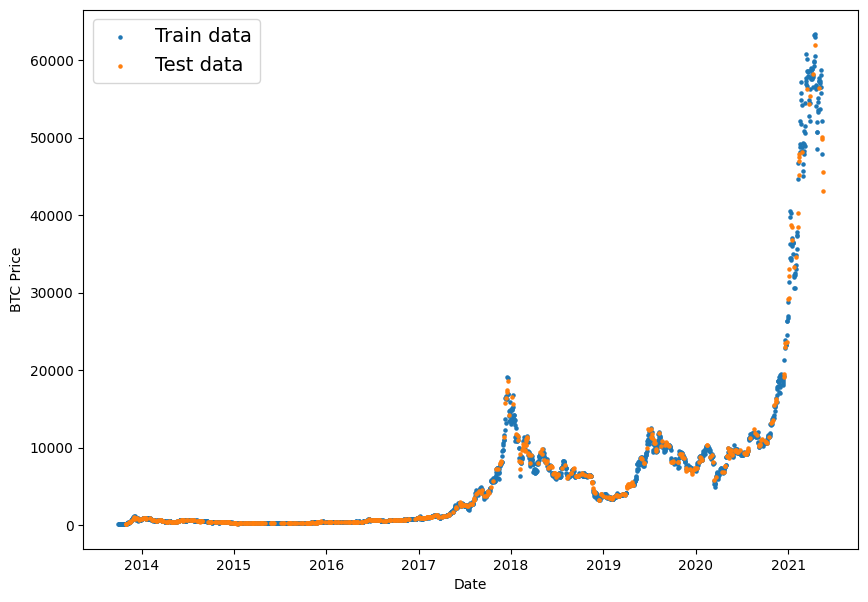

In [12]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

Hmmm... what's wrong with this plot?

Well, let's remind ourselves of what we're trying to do.

We're trying to use the historical price of Bitcoin to predict future prices of Bitcoin.

With this in mind, our seen data (training set) is what?

Prices of Bitcoin in the past.

And our unseen data (test set) is?

Prices of Bitcoin in the future.

Does the plot above reflect this?

No.

Our test data is scattered throughout the training data.

This kind of random split is okay for datasets without a time component (such as images or passages of text for classification problems) but for time series, we've got to take the time factor into account.

To fix this, we've got to split our data in a way that reflects what we're trying to do.

We need to split our historical Bitcoin data to have a dataset that reflects the past (train set) and a dataset that reflects the future (test set).

### Create train & test sets for time series (the right way)

Of course, there's no way we can access data from the future.

But we can engineer our test set to be in the future concerning the training set.

To do this, we can create an arbitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

![image3](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)
*Demonstration of time series split. Rather than a traditional random train/test split, it's best to split the time series data sequentially. Meaning, that the test data should be data from the future when compared to the training data.*

In [13]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

Okay, looks like our custom-made splits are the same lengths as the splits we made with `train_test_split`.

But again, these are numbers on a page.

And you know how the saying goes, trust one eye more than two ears.

Let's visualize.

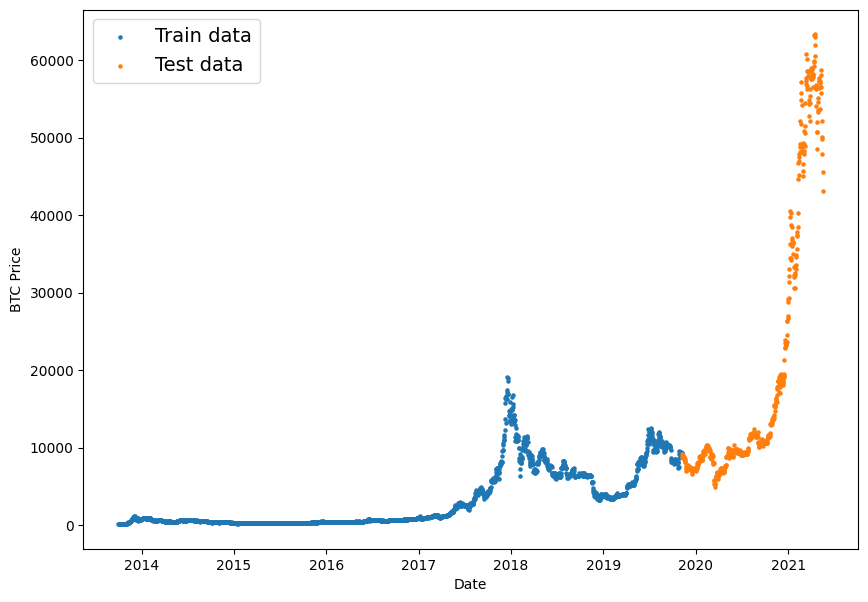

In [14]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

That looks much better!

Do you see what's happened here?

We're going to be using the training set (past) to train a model to try and predict values on the test set (future).

Because the test set is an *artificial* future, we can gauge how our model might perform on actual *future* data.

> 🔑 Note: The amount of data you reserve for your test set is not set in stone. You could have 80/20, 90/10, or 95/5 splits, and in some cases, you might not even have enough data to split into train and test sets (see the resource below). The point is to remember the test set is a pseudo future and not the actual future, it is only meant to give you an indication of how the models you're building are performing.

> 📖 Resource: Working with time series data can be tricky compared to other kinds of data. And there are a few pitfalls to watch out for, such as how much data to use for a test set. The article [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) talks about different things to watch out for when working with time series data, I'd recommend reading it.

### Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

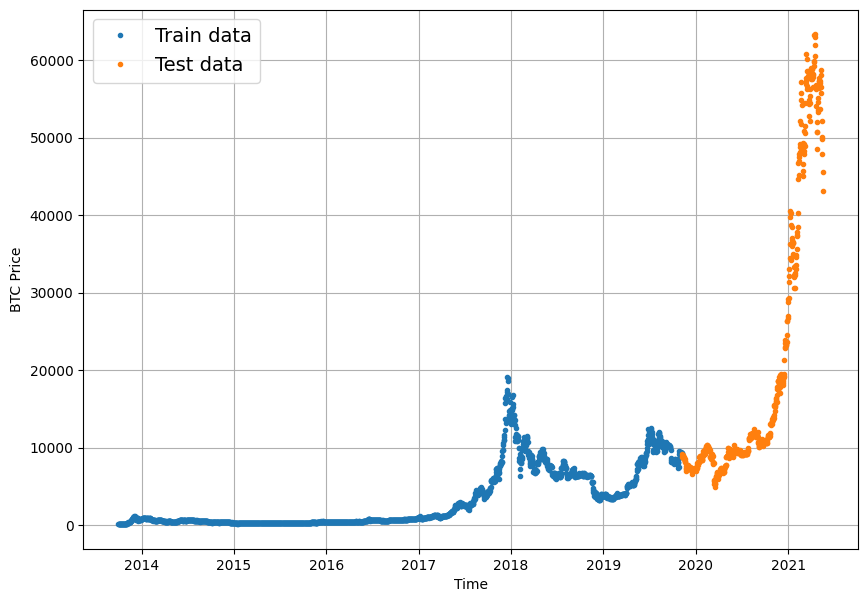

In [16]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

Looking good!

Time for some modeling experiments.

## Modeling Experiments

We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly.

However, just because we can build *almost any* kind of model, doesn't mean it'll perform well/should be used in a production setting.

We'll see what this means as we build and evaluate models throughout.

Before we discuss what modeling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**.

- **horizon** = number of timesteps to predict into future
- **window** = number of timesteps from the past used to predict horizon

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modeling experiments?

|Model Number|Model Type|Horizon size|Window size|Extra data|
|--|--|--|--|--|
|0|	Naïve model (baseline)|	NA|	NA|	NA|
|1|	Dense model|	1|	7|	NA|
|2|	Same as 1|	1	|30|	NA|
|3|	Same as 1|	7|	30|	NA|
|4|	Conv1D|	1|	7|	NA|
|5|	LSTM|	1|	7|	NA|
|6|	Same as 1<br>(but with multivariate data)|	1|	7|	Block reward size|
|7|	[N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf)|	1|	7|	NA|
|8|	Ensemble<br>(multiple models optimized on different loss functions)|	1|	7|	NA|
|9|	Future prediction model<br>(model to predict future values)|	1|	7|	NA|
|10|	Same as 1<br>(but with turkey 🦃 data introduced)|	1|	7|	NA|

> 🔑 Note: To reiterate, as you can see, we can build many types of models for the data we're working with. But that doesn't mean that they'll perform well. Deep learning is a powerful technique but it doesn't always work. And as always, start with a simple model first and then add complexity as needed.

## Model 0: Naïve forecast (baseline)

As usual, let's start with a baseline.

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$
\hat{y}_t = y_{t-1}
$$

In English:

> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).

Sound simple?

Maybe not.

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

> 🔑 Note: For the sake of this notebook, an **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Whereas, in a **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy-in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [17]:
# Create a naïve forecast
naive_forecast = y_test[:-1]                # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:]   # View first 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

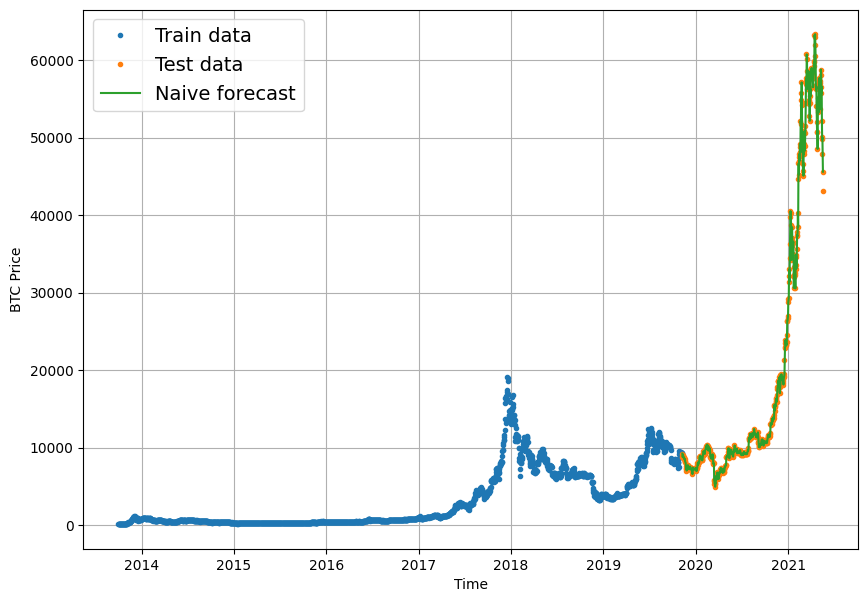

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well.

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

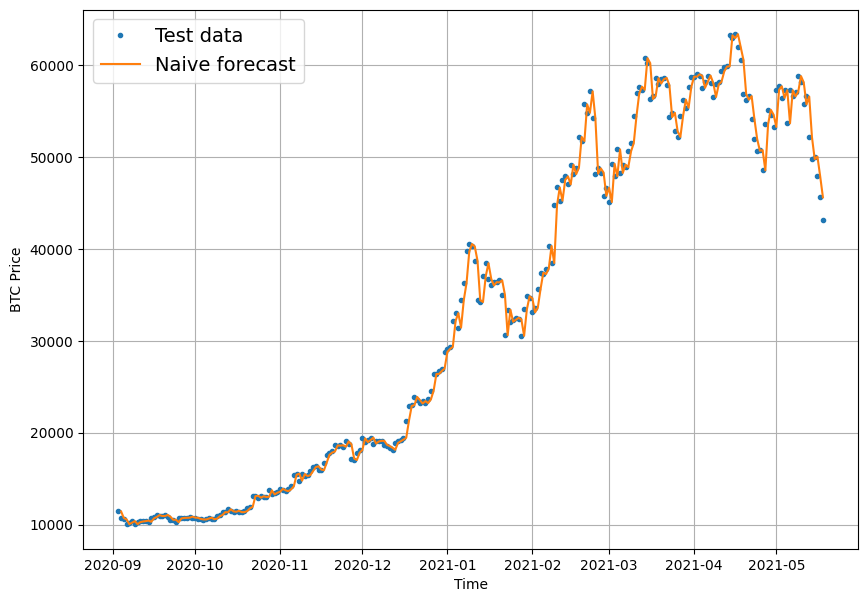

In [19]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a time series model

Time series forecasting often involves predicting a number (in our case, the price of Bitcoin).

And what kind of problem is predicting a number?

Ten points if you said regression.

With this known, we can use regression evaluation metrics to evaluate our time series forecasts.

The main thing we will be evaluating is: **how do our model's predictions (`y_pred`) compare against the actual values (`y_true` or *ground truth values*)?**

> 📖 Resource: We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html), I'd recommend reading through here for a more in-depth overview of what we're going to practice.

For all of the following metrics, **lower is better** (for example an MAE of 0 is better than an MAE of 100).

### Scale-dependent errors

These are metrics that can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD versus Bitcoin forecast values in USD.

|Metric|Details|	Code|
|--|--|--|
|**MAE**<br>(mean absolute error)|	Easy to interpret (a forecast is X amount different from the actual amount).<br>Forecast methods that minimize the MAE will lead to forecasts of the median.|[`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError)|
|RMSE<br>(root mean square error)|Forecasts that minimize the RMSE lead to forecasts of the mean.|`tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

|Metric|	Details|	Code|
|--|--|--|
|**MAPE**<br>(mean absolute percentage error)|Most commonly used percentage error.<br>May explode (not work) if `y=0`.|	[`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE)|
|**sMAPE**<br>(symmetric mean absolute percentage error)|Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors),<br>though it is used in forecasting competitions.	|Custom implementation|

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

|Metric|	Details|	Code|
|--|--|--|
|**MASE**<br>(mean absolute scaled error)|MASE equals one for the naive forecast (or very close to one).<br>A forecast that performs better than the naïve should get <1 MASE.|See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16)|

> 🤔 Question: There are so many metrics... which one should I pay the most attention to? It's going to depend on your problem. However, since its ease of interpretation (you can explain it in a sentence to your grandma), MAE is often a very good place to start.

Since we're going to be evaluating a lot of models, let's write a function to help us calculate evaluation metrics on their forecasts.

First we'll need TensorFlow.

In [20]:
# Let's get TensorFlow!
import tensorflow as tf

And since TensorFlow doesn't have a ready-made version of MASE (mean absolute scaled error), how about we create our own?

We'll take inspiration from [sktime](https://github.com/alan-turing-institute/sktime)'s (Scikit-Learn for time series) [`MeanAbsoluteScaledError`](https://www.sktime.org/en/stable/api_reference/auto_generated/sktime.performance_metrics.forecasting.MeanAbsoluteScaledError.html#sktime.performance_metrics.forecasting.MeanAbsoluteScaledError) class which calculates the MASE.

In [21]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_pred[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season

You'll notice the version of MASE above doesn't take in the training values like sktime's `mae_loss()`. In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.

In [22]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

Looking good! How about we test our function on the naive forecast?

In [23]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.69212395}

Alright, looks like we've got some baselines to beat.

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [24]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

Okay, looking at these two values is starting to give us an idea of how our model is performing:

- The average price of Bitcoin in the test dataset is: $20,056 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

- Each prediction in a naive forecast is on average off by: $567

Is this enough to say it's a good model?

That's up to your interpretation. I'd prefer a model which was closer to the mark.

How about we try and build one?

## Other kinds of time series forecasting models that can be used for baselines and actual forecasts

Since we've got a naïve forecast baseline to work with, it's time we start building models to try and beat it.

And because this course is focused on TensorFlow and deep learning, we're going to be using TensorFlow to build deep learning models to try and improve on our naïve forecasting results.

That being said, there are many other kinds of models you may want to look into for building baselines/performing forecasts.

Some of them may even beat our best-performing models in this notebook, however, I'll leave trying them out for extra-curriculum.

|Model/Library Name|Resource|
|--|--|
|Moving average|	https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/|
|ARIMA<br>(Autoregression Integrated Moving Average)|https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/|
|sktime<br>(Scikit-Learn for time series)	|https://github.com/alan-turing-institute/sktime|
|TensorFlow Decision Forests<br>(random forest, gradient boosting trees)	|https://www.tensorflow.org/decision_forests|
|Facebook Kats<br>(purpose-built forecasting and time series analysis library by Facebook)	|https://github.com/facebookresearch/Kats|
|LinkedIn Greykite<br>(flexible, intuitive and fast forecasts)|https://github.com/linkedin/greykite|



## Format Data Part 2: Windowing dataset

Surely we'd be ready to start building models by now?

We're so close! Only one more step (really two) to go.

We've got to window our time series.

Why do we window?

Windowing is a method to turn a time series dataset into **supervised learning problem**.

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like this:
```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```
Or for the price of Bitcoin, it'd look like:
```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

![image4](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-windows-and-horizons.png)
*Example of windows and horizons for Bitcoin data. Windowing can be used to turn time series data into a supervised learning problem.*

Let's build some functions that take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).

In [25]:
HORIZON = 1     # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

Now we'll write a function to take in an array and turn it into a window and horizon.

In [26]:
# Create function to label windowed data
def get_labeled_windows(x, horizon=1):
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labeling function
test_window, test_label = get_labeled_windows(tf.expand_dims(tf.range(8) + 1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Oh yeah, that's what I'm talking about!

Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Let's write a function which:

1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multiple window steps to index on a target series
4. Uses the `get_labeled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 Resource: The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [30]:
# Create a function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size
    """
    # 1. Create a window of specific window_size (add the horizon on the end for later labeling)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    print(f"Window step:\n {window_step}")

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T # create 2D array of windows of size window_size
    print(f"Window indexes:\n {window_indexes[:3]} \n{window_indexes[-3:]} \n{window_indexes.shape}")

    # 3. Index on the target array (time series) with a 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labeled windows
    windows, labels = get_labeled_windows(windowed_array, horizon=horizon)

    return windows, labels

Phew! A few steps there... let's see how it goes.

In [31]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

Window step:
 [[0 1 2 3 4 5 6 7]]
Window indexes:
 [[0 1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7 8]
 [2 3 4 5 6 7 8 9]] 
[[2777 2778 2779 2780 2781 2782 2783 2784]
 [2778 2779 2780 2781 2782 2783 2784 2785]
 [2779 2780 2781 2782 2783 2784 2785 2786]] 
(2780, 8)


(2780, 2780)

Of course, we have to visualize, visualize, visualize!

In [33]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Labels: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Labels: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Labels: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Labels: [125.96116]


In [34]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑 Note: You can find a function that achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our data later).

## Turning windows into training and test sets

Look how good those windows look! Almost like the stained glass windows on the Sistine Chapel, well, maybe not that good but still.

Time to turn our windows into training and test splits.

We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [35]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

Look at that amazing function, let's test it.

In [36]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Notice the default split of 80% training data and 20% testing data (this split can be adjusted if needed).

How do the first 5 samples of the training windows and labels look?

In [37]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [38]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modeling checkpoint

We're so close to building models. So so so close.

Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.

What I mean by this is for a fair comparison, we want to compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

To fulfill this, we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

That way when evaluating our model we could restore its best-performing configuration from file.

> 🔑 Note: Because of the size of the dataset (smaller than usual), you'll notice our modeling experiment results fluctuate quite a bit during training (hence the implementation of the `ModelCheckpoint` callback to save the best model).

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to a specified file name.

In [39]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                              verbose=0,                                    # only output a limited amount of text
                                              save_best_only=True)                          # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

Finally!

Time to build one of our models.

If you think we've been through a fair bit of preprocessing before getting here, you're right.

Often, preparing data for a model is one of the largest parts of any machine learning project.

And once you've got a good model in place, you'll probably notice far more improvements from manipulating the data (e.g. collecting more, improving the quality) than manipulating the model.

We're going to start by keeping it simple, `model_1` will have:

- A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
- An output layer with linear activation (or no activation)
- Adam optimizer and MAE loss function
- Batch size of 128
- 100 epochs

Why these values?

I picked them out of experimentation.

A batch size of 32 works pretty well too and we could always train for fewer epochs but since the model runs so fast (you'll see in a second, it's because the number of samples we have isn't massive) we might as well train for more.

> 🔑 Note: As always, many of the values for machine learning problems are experimental. A reminder that the values you can set yourself in a machine learning algorithm (the hidden units, the batch size, horizon size, window size) are called [**hyperparameters**](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning). Experimenting to find the best values for hyperparameters is called **hyperparameter tuning**. Whereas parameters learned by a model itself (patterns in the data, formally called weights & biases) are referred to as **parameters**.

Let's import TensorFlow and build our first deep learning model for time series.

In [40]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for reproducibility
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')  # linear activation is the same as having no activation
], name='model_1_dense')                        # give the model a name so we can save it

# Compile model
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='mae',
                metrics=['mae']) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows,                                                # train windows of 7 timesteps of Bitcoin prices
            y=train_labels,                                                 # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])   # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 1s 39ms/step - loss: 578.2271 - mae: 578.2271 - val_loss: 1200.7334 - val_mae: 1200.7334
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 250.6394 - mae: 250.6394 - val_loss: 1257.4907 - val_mae: 1257.4907
Epoch 3/100
18/18 [==============================] - 0s 20ms/step - loss: 210.8407 - mae: 210.8407 - val_loss: 1152.1738 - val_mae: 1152.1738
Epoch 4/100
18/18 [==============================] - 0s 21ms/step - loss: 191.3166 - mae: 191.3166 - val_loss: 1128.1542 - val_mae: 1128.1542
Epoch 5/100
18/18 [==============================] - 0s 21ms/step - loss: 183.9256 - mae: 183.9256 - val_loss: 1021.5335 - val_mae: 1021.5335
Epoch 6/100
18/18 [==============================] - 0s 20ms/step - loss: 184.1699 - mae: 184.1699 - val_loss: 960.8642 - val_mae: 960.8642
Epoch 7/100
18/18 [==============================] - 0s 21ms/step - loss: 166.9351 - mae: 166.9351 - val_loss: 886.4742 - val_mae: 886.4742
Epoch 8/100

Because of the small size of our data (less than 3000 total samples), the model trains very fast.

Let's evaluate it.

In [41]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 691.2744 - mae: 691.2744


[691.2744140625, 691.2744140625]

You'll notice the model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if we load in the version of `model_1` which was saved to file using the `ModelCheckpoint` callback, we should see an improvement in results.

In [43]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 565.0714 - mae: 565.0714


[565.0713500976562, 565.0713500976562]

Much better! Due to the fluctuating performance of the model during training, loading back in the best-performing model sees a sizeable improvement in MAE.

## Making forecasts with a model (on the test dataset)

We've trained a model and evaluated it on the test data, but the project we're working on is called BitPredict 💰📈 so how do you think we could use our model to make predictions?

Since we're going to be running more modeling experiments, let's write a function that:

1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [44]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data.

    Parameters
    ----------
    model: trained model
    input_data: windowed input data (same kind of data model was trained on)

    Returns model predictions on input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions

Nice!

Now let's use our `make_preds()`| and see how it goes.

In [45]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8854.463, 8793.745, 9075.654, 8776.579, 8740.178, 8771.849,
        8694.416, 8518.059, 8482.931, 8548.609], dtype=float32)>)

> 🔑 Note: With these outputs, our model isn't *forecasting* yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudo future.

Excellent! Now we've got some prediction values, let's use the `evaluate_preds()` we created before to compare them to the ground truth.

In [49]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 565.0714,
 'mse': 1155194.9,
 'rmse': 1074.7999,
 'mape': 2.5086892,
 'mase': 0.6910161}

How did our model go? Did it beat the naïve forecast?

In [50]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.69212395}

It looks like our naïve model beats our first deep model on nearly every metric.

That goes to show the power of the naïve model and the reason for having a baseline for any machine learning project.

And of course, no evaluation would be finished without visualizing the results.

Let's use the `plot_time_series()` function to plot `model_1_preds` against the test data.

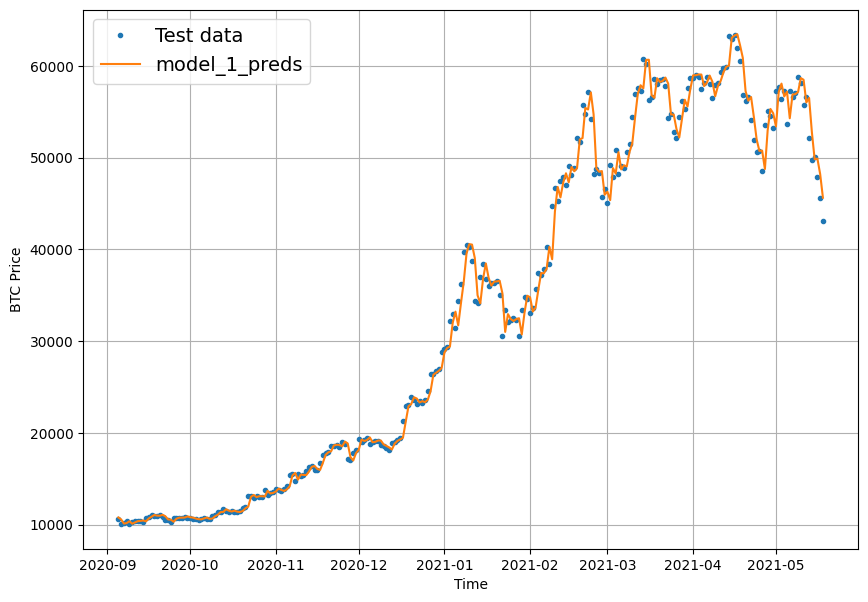

In [51]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.

With our current model setup, how do you think we'd make forecasts for the future?

Think about it for now, we'll cover this later on.

## Model 2: Dense (window = 30, horizon = 1)

A naïve model is currently beating our handcrafted deep learning model.

We can't let this happen.

Let's continue our modeling experiments.

We'll keep the previous model architecture but use a window size of 30.

In other words, we'll use the previous 30 days of Bitcoin prices to try and predict the next day's price.

![image5](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-price-window-for-one-month.png)
*Example of Bitcoin prices windowed for 30 days to predict a horizon of 1.*

> 🔑 Note: Recall from before, the window size (how many timesteps to use to fuel a forecast) and the horizon (how many timesteps to predict into the future) are **hyperparameters**. This means you can tune them to try and find values will result in better performance.

We'll start our second modeling experiment by preparing datasets using the functions we created earlier.

In [61]:
HORIZON = 1         # predict one step at a time
WINDOW_SIZE = 30    # use 30 timesteps in the past

In [62]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

Window step:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30]]
Window indexes:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 29 30 31]
 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
  26 27 28 29 30 31 32]] 
[[2754 2755 2756 2757 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767
  2768 2769 2770 2771 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781
  2782 2783 2784]
 [2755 2756 2757 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768
  2769 2770 2771 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781 2782
  2783 2784 2785]
 [2756 2757 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769
  2770 2771 2772 2773 2774 2775 2776 2777 2778 2779 2780 2781 2782 2783
  2784 2785 2786]] 
(2757, 31)


(2757, 2757)

In [63]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

Data prepared!

Now let's construct `model_2`, a model with the same architecture as `model_1` as well as the same training routine.

In [64]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name='model_2_dense')

model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='mae')

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Once again, training goes nice and fast.

Let's evaluate our model's performance.

In [65]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 653.2903


653.290283203125

Hmmm... is that the best it did?

How about we try loading in the best performing `model_2` which was saved to file thanks to our `ModelCheckpoint` callback?

In [66]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 615.2935


615.29345703125

Excellent! Loading back in the best-performing model sees a performance boost.

But let's not stop there, let's make some predictions with `model_2` and then evaluate them just as we did before.

In [67]:
# Get forecast predictions
model_2_preds = make_preds(model_2, input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [68]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 615.29346,
 'mse': 1284364.1,
 'rmse': 1133.2979,
 'mape': 2.832772,
 'mase': 0.70973784}

It looks like `model_2` performs worse than the naïve model as well as `model_1`!

Does this mean a smaller window size is better? (I'll leave this as a challenge you can experiment with)

How do the predictions look?

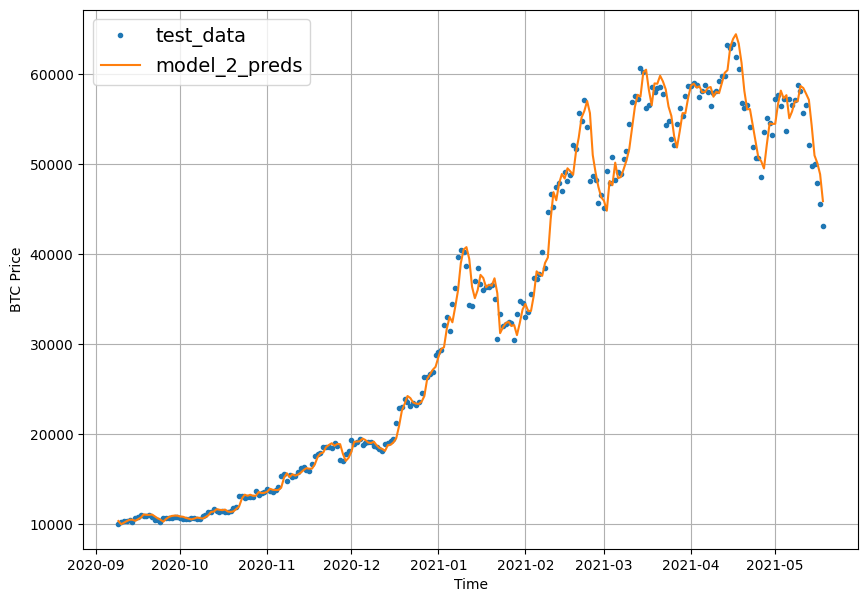

In [69]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.

In [70]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

Window step:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36]]
Window indexes:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36]
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 29 30 31 32 33 34 35 36 37]
 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
  26 27 28 29 30 31 32 33 34 35 36 37 38]] 
[[2748 2749 2750 2751 2752 2753 2754 2755 2756 2757 2758 2759 2760 2761
  2762 2763 2764 2765 2766 2767 2768 2769 2770 2771 2772 2773 2774 2775
  2776 2777 2778 2779 2780 2781 2782 2783 2784]
 [2749 2750 2751 2752 2753 2754 2755 2756 2757 2758 2759 2760 2761 2762
  2763 2764 2765 2766 2767 2768 2769 2770 2771 2772 2773 2774 2775 2776
  2777 2778 2779 2780 2781 2782 2783 2784 2785]
 [2750 2751 2752 2753 2754 2755 2756 2757 2758 2759 2760 2761 2762 2763
  2764 2765 2766 2767 2768 2769 2770 2771 2772

(2751, 2751)

And we'll split the full dataset windows into training and test sets.

In [71]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

Now let's build, compile, fit, and evaluate a model.

In [72]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [73]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1378.8805


1378.8804931640625

To compare apples to apples (best-performing model to best-performing model), we've got to load in the best version of `model_3`.

In [74]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1226.9182


1226.918212890625

In this case, the error will be higher because we're predicting 7 steps at a time.

This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).

Let's make predictions with our model using the `make_preds()` function and evaluate them using the `evaluate_preds()` function.

In [75]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9311.197, 9288.403, 9175.72 , 9428.727, 9291.47 , 9454.346,
        9651.888],
       [9055.815, 9066.38 , 8666.393, 9047.125, 9098.986, 9260.618,
        9268.995],
       [8955.896, 8987.251, 8684.043, 8916.678, 9064.13 , 9169.285,
        9092.452],
       [9100.491, 9213.903, 8923.915, 9101.369, 9190.183, 9423.43 ,
        9199.419],
       [8977.814, 8935.909, 9003.696, 8895.192, 8929.005, 9112.965,
        8955.688]], dtype=float32)>

In [76]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 578.46356 ,  332.2027  ,  334.85797 ,  538.07825 ,  418.548   ,
         390.4017  ,  450.6472  ,  505.66818 ,  470.70193 ,  650.43695 ,
         890.2545  ,  910.2338  ,  866.1243  ,  783.22253 ,  652.22595 ,
         320.94183 ,  180.23277 ,  229.63387 ,  181.39558 ,  213.27623 ,
         225.2364  ,  265.27728 ,  438.42654 ,  346.3755  ,  285.00363 ,
         163.81223 ,  218.18332 ,  154.11119 ,  175.84752 ,  150.01332 ,
         282.90707 ,  398.5975  ,  304.2488  ,  344.36246 ,  287.3143  ,
         280.39795 ,  309.5281  ,  242.21059 ,  231.97035 ,  235.32338 ,
         456.65717 ,  117.22663 ,  127.12305 ,   68.71205 ,   78.29283 ,
         154.64621 ,   89.16225 ,  138.53285 ,  145.2844  ,  164.37381 ,
         110.322685,  101.208496,  163.16531 ,  151.85959 ,  230.9511  ,
         386.30127 ,  493.0988  ,  510.148   ,  512.5578  ,  544.16425 ,
         422.83936 ,  225.42746 ,  262.50766 ,  353.36942 ,  405.94907 ,
         459.30063 ,  443.1031  ,  606.10315

## Make our evaluation function work for larger horizons

You'll notice the outputs for `model_3_results` are multi-dimensional.

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [77]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different sized metrics (for longer horizons, reduce to single number)
    if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

Now we've updated `evaluate_preds()` to work with multiple shapes, how does it look?

In [78]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1226.9181,
 'mse': 5259635.0,
 'rmse': 1411.7362,
 'mape': 5.5500345,
 'mase': 0.8814059}

Time to visualize.

If our prediction evaluation metrics were multi-dimensional, how do you think the predictions would look like if we plot them?

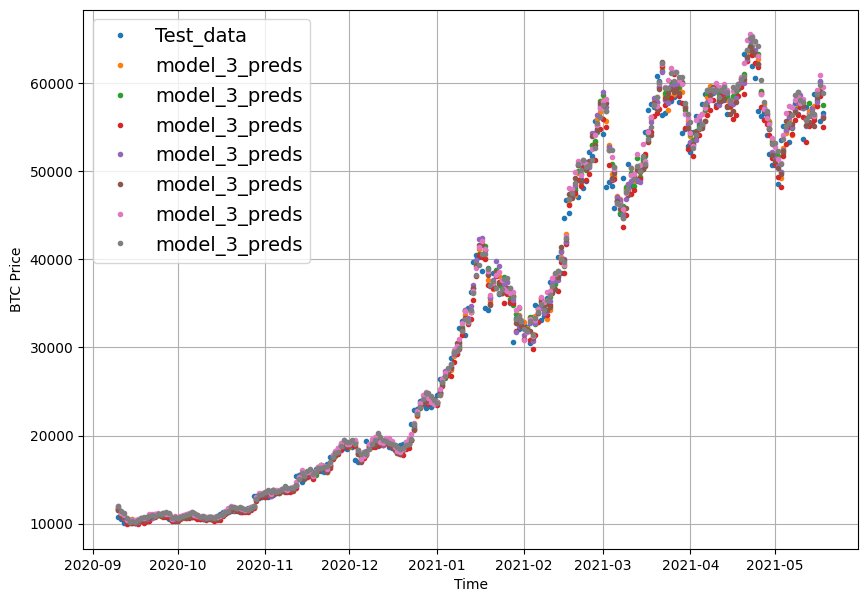

In [79]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

When we try to plot our multi-horizon predictions, we get a funky-looking plot.

Again, we can fix this by aggregating our model's predictions.

> 🔑 Note: Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7 days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.

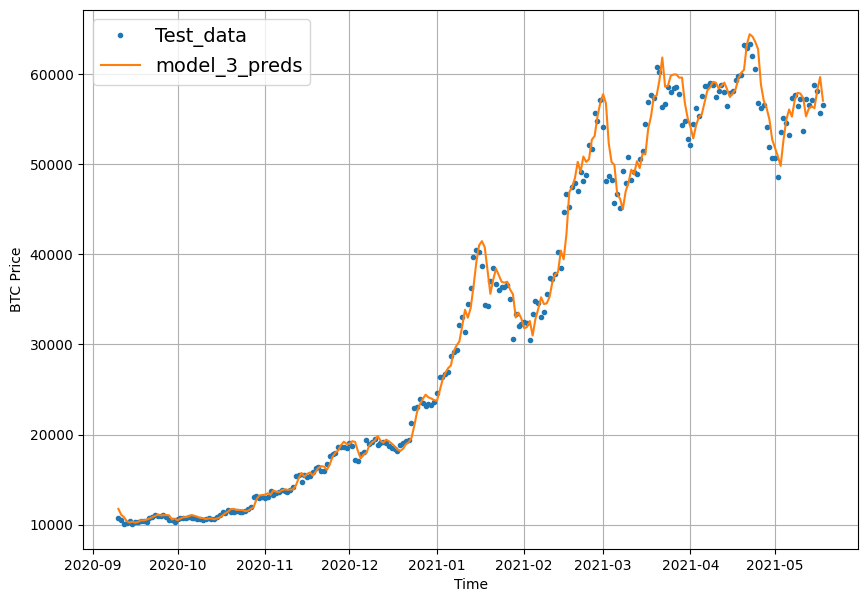

In [80]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

## Which of our models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

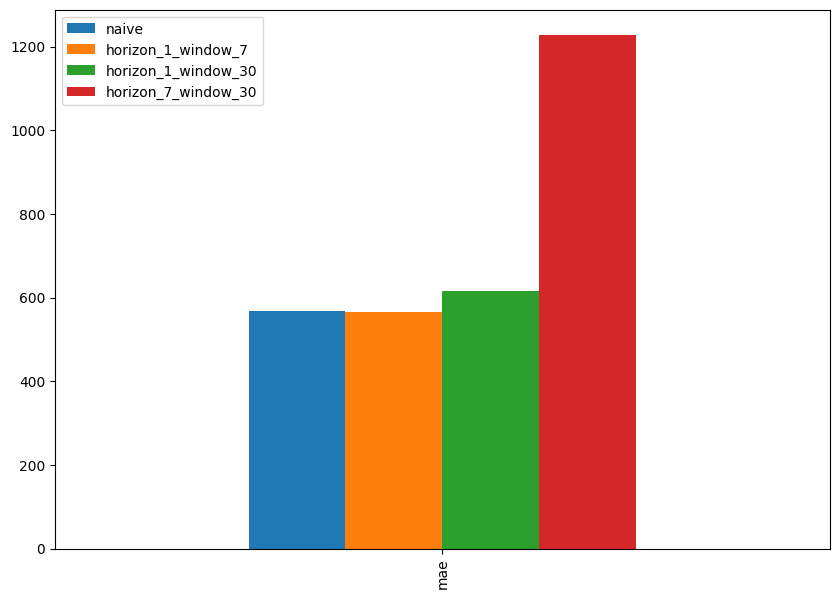

In [81]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Woah, our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing closest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modeling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

> 🔑 Note: You might be wondering, why are the naïve results so good? One of the reasons could be due to the presence of **autocorrelation** in the data. If a time series has autocorrelation it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.

> 📖 Resource: For more on how autocorrelation influences a model's predictions, see the article [*How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls*](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) by Vegard Flovik

## Model 4: Conv1D

Onto the next modeling experiment!

This time, we'll be using a Conv1D model. As we saw in the sequence modeling notebook, Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

![image6](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-forecast-in-seq2seq-terms.png)
*Framing Bitcoin forecasting in seq2seq (sequence to sequence) terms. Using a window size of 7 and a horizon of one results in a many-to-one problem. Using a window size of >1 and a horizon of >1 results in a many-to-many problem. The diagram comes from Andrei Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).*

Before we build a Conv1D model, let's recreate our datasets.

In [82]:
HORIZON = 1     # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [83]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

Window step:
 [[0 1 2 3 4 5 6 7]]
Window indexes:
 [[0 1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7 8]
 [2 3 4 5 6 7 8 9]] 
[[2777 2778 2779 2780 2781 2782 2783 2784]
 [2778 2779 2780 2781 2782 2783 2784 2785]
 [2779 2780 2781 2782 2783 2784 2785 2786]] 
(2780, 8)


(2780, 2780)

In [84]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Data windowed!

Now, since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` (by default this is 32 but we can change it) is handled for us but the other values will be:

- `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin
- `input_dim = HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension.

In [85]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a [`tf.keras.layers.Lamdba`](https://keras.io/api/layers/core_layers/lambda/) (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer that can be used with a model.

Let's try it out.

In [86]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))  # add an extra dimension for timesteps
print(f"Original shape: {x.shape}")                                     # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}")                  # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


Looking good!

Now we've got a Lambda layer, let's build, compile, fit, and evaluate a Conv1D model on our data.

> 🔑 Note: If you run the model below without the Lambda layer, you'll get an input shape error (one of the most common errors when building neural networks).

In [87]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    # Create Lambda layer to rehsape inputs, without this layer, the model will error
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requireme
    layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
    layers.Dense(HORIZON)
], name='model_4_conv1D')

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

What does the Lambda layer look like in a summary?

In [88]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_8 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The Lambda layer appears the same as any other regular layer.

Time to evaluate the Conv1D model.

In [89]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 569.4214


569.42138671875

In [90]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8863.034, 8765.175, 8987.735, 8756.587, 8722.712, 8717.332,
       8673.629, 8500.592, 8447.707, 8502.462], dtype=float32)>

In [91]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.4214,
 'mse': 1172168.6,
 'rmse': 1082.6674,
 'mape': 2.5464003,
 'mase': 0.6832319}

## Model 5: RNN (LSTM)

As you might've guessed, we can also use a recurrent neural network to model our sequential time series data.

> 📖 Resource: For more on the different types of recurrent neural networks you can use for sequence problems, see the [Recurrent Neural Networks section of notebook 08](https://dev.mrdbourke.com/tensorflow-deep-learning/08_introduction_to_nlp_in_tensorflow/#recurrent-neural-networks-rnns).

Let's reuse the same data we used for the Conv1D model, except this time we'll create an [LSTM-cell-powered](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) RNN to model our Bitcoin data.

Once again, one of the most important steps for the LSTM model will be getting our data into the right shape.

The [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer takes a tensor with `[batch, timesteps, feature]` dimensions.

As mentioned earlier, the `batch` dimension gets taken care of for us but our data currently only has the `feature` dimension (`WINDOW_SIZE`).

To fix this, just like we did with the `Conv1D` model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.

In [92]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)      # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation='relu')(x)                          # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name='model_5_lstm')

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [93]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 587.8281


587.828125

Now we've got the best-performing LSTM model loaded in, let's make predictions with it and evaluate them.

In [94]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8939.07 , 8791.843, 8965.61 , 8820.682, 8721.775, 8712.329,
       8714.692, 8546.602, 8450.938, 8515.046], dtype=float32)>

In [95]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 587.8282,
 'mse': 1246472.2,
 'rmse': 1116.4552,
 'mape': 2.6486554,
 'mase': 0.6958152}

Hmmm... it seems even with an LSTM-powered RNN we weren't able to beat our naïve model results.

Perhaps adding another variable will help?

> 🔑 Note: I'm putting this here again as a reminder that because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue in on this now.

## Make a multivariate time series

So far all of our models have barely kept up with the naïve forecast.

And so far all of them have been trained on a single variable (also called univariate time series): the historical price of Bitcoin.

If predicting the price of Bitcoin using the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help.

More information is a vague term because we could actually feed almost anything to our model(s) and they would still try to find patterns.

For example, we could use the historical price of Bitcoin as well as anyone with the name [Daniel Bourke Tweeted](https://twitter.com/mrdbourke) on that day to predict the future price of Bitcoin.

But would this help?

Probably not.

What would be better is if we passed our model something related to Bitcoin (again, this is quite vague, since in an open system like a market, you could argue everything is related).

This will be different for almost every time series you work on but in our case, we could try to see if the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) adds any predictive power to our model(s).

What is the Bitcoin block reward size?

The Bitcoin block reward size is the number of Bitcoins someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting in January 2009) to 25 on November 28, 2012.

Let's encode this information into our time series data and see if it helps a model's performance.

> 🔑 Note: Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from **univariate** (only the historical price of Bitcoin) to **multivariate** (the price of Bitcoin as well as the block reward size).

In [96]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Alright, time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

|Block Reward|	Start Date|
|--|--|
|50|	3 January 2009 (2009-01-03)|
|25|	28 November 2012|
|12.5|	9 July 2016|
|6.25|	11 May 2020|
|3.125|	TBA (expected 2024)|
|1.5625|	TBA (expected 2028)|

> 🔑 Note: Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [97]:
# Block reward values
block_reward_1 = 50     # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25     # 28 November 2012
block_reward_3 = 12.5   # 9 July 2016
block_reward_4 = 6.25   # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

We're going to get the days (indexes) for different block reward values.

This is important because if we're going to use multiple variables for our time series, they have to have the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

> 🔑 Note: For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.

In [98]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

Now we can add another feature to our dataset `block_reward` (this gets lower over time so it may lead to increasing prices of Bitcoin).

In [100]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


Woohoo! We've officially added another variable to our time series data.

Let's see what it looks like.

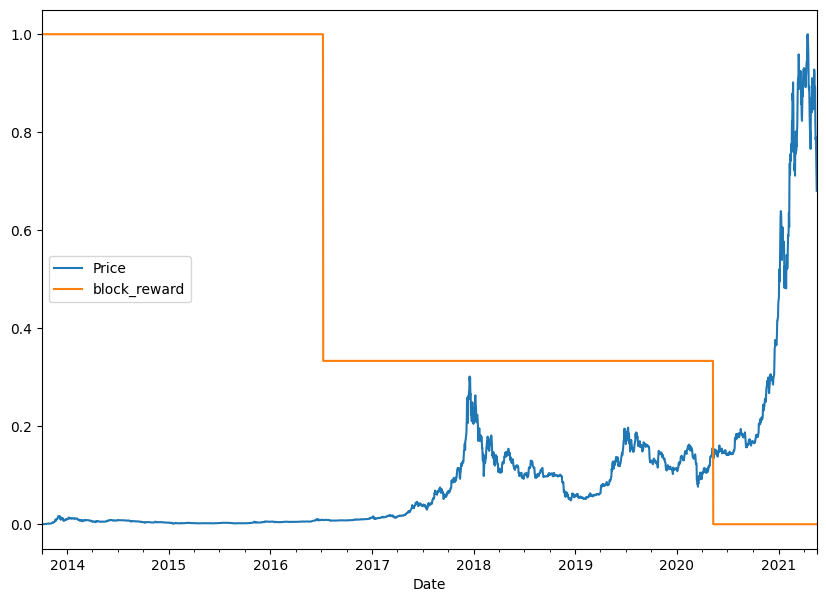

In [101]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.